In [52]:
import numpy as np
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.autonotebook import *
from transformers import AlbertTokenizer

from pvp import *
from model import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [24]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


In [25]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2", do_lower_case=True)

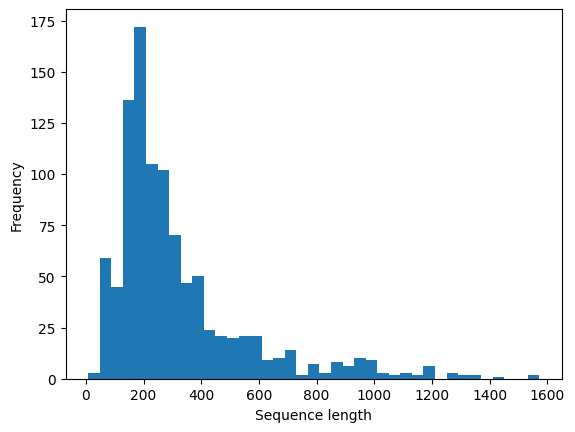

In [26]:
import matplotlib.pyplot as plt 

rand = list(np.random.randint(0, len(dataset), 1000))
reviews=dataset[rand]['review']
tokenized = [tokenizer.tokenize(review) for review in reviews]
L = [len(tok) for tok in tokenized]

plt.hist(L, bins='auto')
plt.xlabel('Sequence length')
plt.ylabel('Frequency')
plt.show()


In [125]:
import importlib
import pvp
importlib.reload(pvp)

def preprocessing_fn(x, tokenizer,pvp):
    transformed_data={}
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    pattern,verbalized_label=pvp.transform_data(x["review"],x["label"])
    transformed_data["input_ids"] = tokenizer(
        pattern,
        add_special_tokens=False,
        truncation=True,
        max_length=512,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    transformed_data["input_ids"]=[tokenizer.cls_token_id]+transformed_data["input_ids"]+[tokenizer.mask_token_id]
    transformed_data["target"]=tokenizer(
        verbalized_label,
        add_special_tokens=False,
        truncation=True,
        max_length=512,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    
    return transformed_data


In [126]:
pvp=PVP(1,1)
pvp.transform_data('it was awesome',1)

('the review is: it was awesome. Is it a positive review?', 'yes')

In [127]:
n_samples = 1000 
dataset=dataset.shuffle()
samples=dataset.select(range(n_samples))
tokenized=samples.map(preprocessing_fn , fn_kwargs={"tokenizer":tokenizer, "pvp":pvp})
to_keep=["input_ids","target"]
tokenized = tokenized.select_columns(to_keep)

split=tokenized.train_test_split(test_size=1-(32/n_samples))
train_set = split["train"]
valid_set = split["test"]

train_set,valid_set

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

(Dataset({
     features: ['input_ids', 'target'],
     num_rows: 32
 }),
 Dataset({
     features: ['input_ids', 'target'],
     num_rows: 968
 }))

In [67]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "input_ids" and "target".
        features = [{"input_ids": x["input_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="longest", max_length=512, return_tensors="pt"
        )
        target = torch.tensor([x["target"] for x in batch])
        return {"input_ids": features["input_ids"], "target": target}
    
data_collator = DataCollator(tokenizer)

In [68]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

n_train, n_valid

(32, 968)

In [80]:
batch = next(iter(train_dataloader))

print(batch['input_ids'].shape)
print(batch['target'].shape)

torch.Size([32, 512])
torch.Size([32, 1])
